# Title

## Overview
The 2018 Kaggle Survey is a highly interesting dataset comprised of questions around many topics (e.g. tools used for Machine Learning and data analysis, industry, geography). This analysis attempts to outline patterns around gender pay gap. Not surprisingly, a considerable income discrepancy is found between genders, impacting women negatively. The research then moves towards questioning whether this difference in income is justified.

## Data Preparation
For this analysis, some of the data points have been manipulated respective to the original dataset. These are:
- **Gender**: only the samples where the person who filled the survey declared being either a man or a woman have been kept.
- **Range data**: answers on dimensions such as income, age or experience (e.g. in current role, coding) come mostly in two flavours: 1) as ranges (e.g. 30-34 years), in these cases an average was made between the two (e.g. 32 years); and 2) as a number with a "+" sign meaning *more than* (e.g. $500,000+), in these cases just the number was kept (e.g. 500,000).
- When considered appropriate, data has been deliberately left out in certain visualizations with the aim of better represent the reality. For instance, when showing *average income by age*, only data points that represented 50 or more respondents were included.

In [43]:
# data preparation

import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import ConnectionPatch
from matplotlib.ticker import FormatStrFormatter
from textwrap import wrap

plt.style.use('fivethirtyeight')

# multiple_choice = pd.read_csv('../input/multipleChoiceResponses.csv', low_memory=False)
multiple_choice = pd.read_csv('./data/multipleChoiceResponses.csv', low_memory=False)

def convert_salary(salary):

    if salary == '500,000+':
        return 500000
    else:
        try:
            a, b = salary.replace(',','').split('-')
            avg = (int(a)*1000+int(b))/2
            return avg
        except:
            return None

def convert_xp(xp, return_type):
    if xp == '30 +':
        xp = 30
    elif xp == '40+ years':
        xp = 40
    elif xp == '< 1 year':
        xp = 0.5
    else:
        try:
            a, b = xp.replace(' years', '').split('-')
            xp = (int(a)+int(b))/2
        except:
            return None
        
    if return_type == 'years':
        return xp
    elif return_type == 'seniority level':
        if xp < 3:
            return 0
        elif xp < 6:
            return 1
        else:
            return 2
    else:
        return None   

def convert_age(age):
    if age == '80+':
        return 80
    else:
        try:
            a, b = age.split('-')
            return (int(a)+int(b))/2
        except:
            return None

def convert_ind_projects(response):

    if response == 'Independent projects are much less important than academic achievements':
        return 0
    elif response == 'Independent projects are slightly less important than academic achievements':
        return 1
    elif response == 'Independent projects are equally important as academic achievements':
        return 2
    elif response == 'Independent projects are slightly more important than academic achievements':
        return 3
    elif response == 'Independent projects are much more important than academic achievements':
        return 4
    else:
        return None

def importance_scale(response):

    if response == 'Not at all important':
        return 0
    elif response == 'Slightly important':
        return 1
    elif response == 'Very important':
        return 2
    else:
        return None
    
def convert_education(education):
    
    education = str(education)
    
    if education.startswith('Bach'):
        return 'Bachelor'
    elif education.startswith('Doct'):
        return 'Doctor'
    elif education.startswith('Mast'):
        return 'Master'
    elif education.startswith('Prof'):
        return 'Professional'
    elif education.startswith('Some coll'):
        return 'Non-finished University'
    else:
        return None

df = pd.DataFrame()
df['gender'] = multiple_choice.Q1[1:]
df['current_role_xp'] = multiple_choice.Q8[1:].apply(convert_xp, args = ('years',))
df['coding_xp'] = multiple_choice.Q24[1:].apply(convert_xp, args = ('years',))
df['ml_xp'] = multiple_choice.Q25[1:].apply(convert_xp, args = ('years',))
df['current_role_xp_level'] = multiple_choice.Q8[1:].apply(convert_xp, args = ('seniority level',))
df['coding_xp_level'] = multiple_choice.Q24[1:].apply(convert_xp, args = ('seniority level',))
df['ml_xp_level'] = multiple_choice.Q25[1:].apply(convert_xp, args = ('seniority level',))
df['income'] = multiple_choice.Q9[1:].apply(convert_salary)
df['geography'] = multiple_choice.Q3[1:]
df['original_age'] = multiple_choice.Q2[1:]
df['age'] = multiple_choice.Q2[1:].apply(convert_age)
df['ind_projects_importance'] = multiple_choice.Q40[1:].apply(convert_ind_projects)
df['ml_fairness'] = multiple_choice.Q41_Part_1[1:].apply(importance_scale)
df['ml_explainability'] = multiple_choice.Q41_Part_2[1:].apply(importance_scale)
df['ml_reproducibility'] = multiple_choice.Q41_Part_3[1:].apply(importance_scale)
df['title'] = multiple_choice.Q6[1:]
df['industry'] = multiple_choice.Q7[1:]
df['education'] = multiple_choice.Q4[1:].apply(convert_education)

df = df[df.gender.isin(['Male', 'Female'])]

fig_height = [8]
fig_width = [16]
title_fontsize = [20]
axis_labels_fontsize = [20]
tick_fontsize = [15]
legend_fontsize = [15]

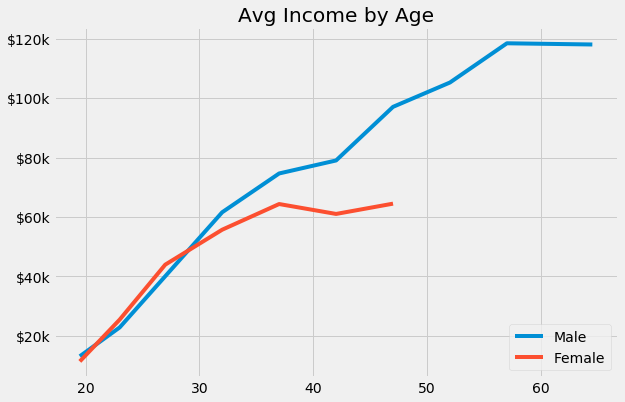

In [10]:
df_plot = sqldf("""
with bd as (
    select gender as Gender, age, avg(income)*1.0/1000 as income_mean, sum(case when income is not null then 1 else 0 end) as income_count
    from df
    group by 1, 2
)
, fl as (
    select *
    from bd
    where Gender = 'Female'
    and income_count >= 50
)
, ml as (
    select *
    from bd
    where Gender = 'Male'
    and income_count >= 50
)
, ages as (
    select distinct fl.age
    from fl
    join ml on fl.age = ml.age
)
select *
from fl
--where age in (select * from ages)
UNION ALL
select *
from ml
--where age in (select * from ages)
""")

df_plot.sort_values(by='age', inplace=True)


fig, ax = plt.subplots(figsize=(9,6))

ax.plot('age', 'income_mean', data=df_plot[df_plot['Gender']=='Male'])
ax.plot('age', 'income_mean', data=df_plot[df_plot['Gender']=='Female'])
ax.legend(['Male', 'Female'], loc=4)
ax.set_title('Avg Income by Age')
ax.yaxis.set_major_formatter(FormatStrFormatter('$%.0fk'))

plt.show()

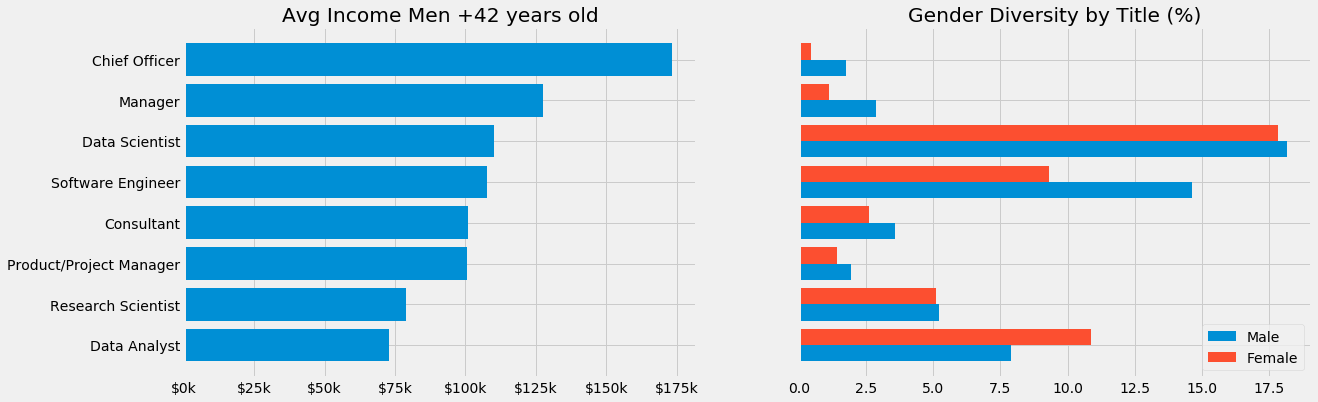

In [11]:
df_plot = sqldf("""
select title, gender, avg(income)*1.0/1000 as income_mean, count(*)
from df
where age > 42 and gender = 'Male' and title is not null and income is not null and title != 'Other'
group by 1, 2
having count(*) >= 50
order by avg(income) desc
limit 10
""")


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6), sharey=True)

df_plot.sort_values(by='income_mean', ascending=True, inplace=True)

yticks = np.arange(len(df_plot.title))
yticklabels = list(df_plot.title)

ax1.barh(yticks, 'income_mean', data=df_plot)
ax1.set_title('Avg Income Men +42 years old', )
ax1.xaxis.set_major_formatter(FormatStrFormatter('$%.0fk'))
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticklabels)

df_plot = sqldf("""
with high_paying_titles as (
    select title, gender, avg(income)*1.0/1000 as income_mean, count(*)
    from df
    where age > 42 and gender = 'Male' and title is not null and income is not null and title != 'Other'
    group by 1, 2
    having count(*) >= 50
    order by avg(income) desc
    limit 10
)
, total_counts as (
    select gender, count(*) as gender_count
    from df
    where title is not null
    group by 1
)
select df.title, df.gender, tc.gender_count, count(*), 100*count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Female' and df.title in (select title from high_paying_titles)
group by 1, 2, 3
UNION ALL
select df.title, df.gender, tc.gender_count, count(*), 100*count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Male' and df.title in (select title from high_paying_titles)
group by 1, 2, 3
""")


df_plot = df_plot.pivot(index='title', columns='gender', values='gender_perc')


df_plot = df_plot.reindex(yticklabels)

ax2.barh(yticks-0.2, df_plot.Male, 0.4, label='Male')
ax2.barh(yticks+0.2, df_plot.Female, 0.4, label='Female')
ax2.legend(['Male', 'Female'], loc=4)
ax2.set_title('Gender Diversity by Title (%)')

plt.show()

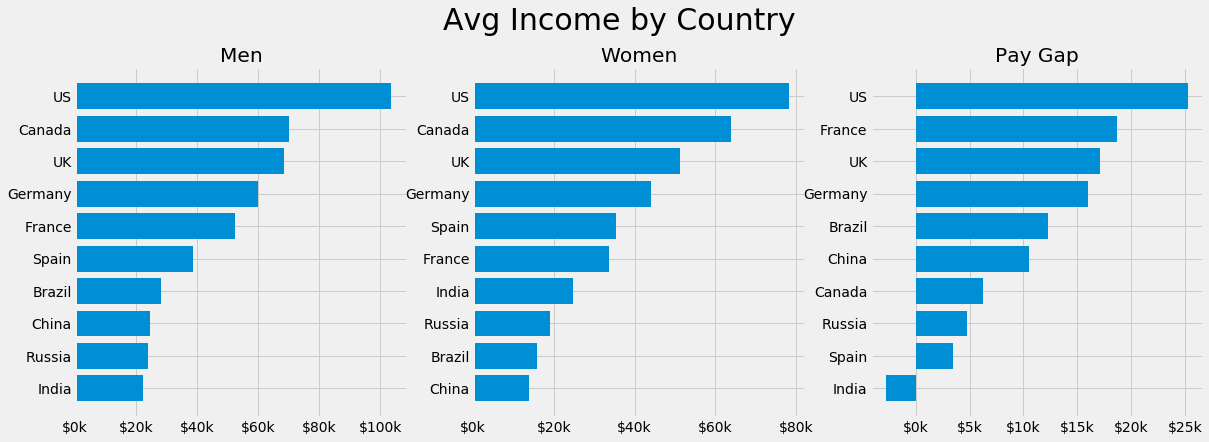

In [13]:
df_plot = sqldf("""
with bd as (
    select gender, geography, avg(income)*1.0/1000 as income_mean, sum(case when income is not null then 1 else 0 end) as income_count
    from df
    where geography != 'Other'
    group by 1, 2
)
, fl as (
    select *
    from bd
    where gender = 'Female'
    and income_count >= 50
)
, ml as (
    select *
    from bd
    where gender = 'Male'
    and income_count >= 50
)
, geos as (
    select distinct fl.geography
    from fl
    join ml on fl.geography = ml.geography
)
select case when lower(fl.geography) like '%united%states%' then 'US'  
            when lower(fl.geography) like '%united%kingdom%' then 'UK' else fl.geography end as geography
    , fl.income_mean as fl_income
    , ml.income_mean as ml_income
    , (ml.income_mean-fl.income_mean) as income_gap
    , case when (ml.income_mean-fl.income_mean) > 0 then 'positive' else 'positive' end as gap_direction
from fl
join ml on fl.geography = ml.geography
where fl.geography in (select * from geos)
order by (ml.income_mean-fl.income_mean) desc
"""
)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
fig.suptitle('Avg Income by Country', fontsize=30, y=1.02)

dfp = df_plot.sort_values(by='ml_income')
yticks = np.arange(len(dfp.geography))
yticklabels = list(dfp.geography)
yticklabels = ['\n'.join(wrap(l, 30)) for l in yticklabels]

ax1.barh(yticks, 'ml_income', data=dfp)
ax1.set_title('Men')
ax1.xaxis.set_major_formatter(FormatStrFormatter('$%.0fk'))
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticklabels)




dfp = df_plot.sort_values(by='fl_income')
yticks = np.arange(len(dfp.geography))
yticklabels = list(dfp.geography)
yticklabels = ['\n'.join(wrap(l, 30)) for l in yticklabels]

ax2.barh(yticks, 'fl_income', data=dfp)
ax2.set_title('Women')
ax2.xaxis.set_major_formatter(FormatStrFormatter('$%.0fk'))
ax2.set_yticks(yticks)
ax2.set_yticklabels(yticklabels)




dfp = df_plot.sort_values(by='income_gap')
yticks = np.arange(len(dfp.geography))
yticklabels = list(dfp.geography)
yticklabels = ['\n'.join(wrap(l, 30)) for l in yticklabels]

ax3.barh(yticks, 'income_gap', data=dfp)
ax3.set_title('Pay Gap')
ax3.xaxis.set_major_formatter(FormatStrFormatter('$%.0fk'))
ax3.set_yticks(yticks)
ax3.set_yticklabels(yticklabels)

plt.show()

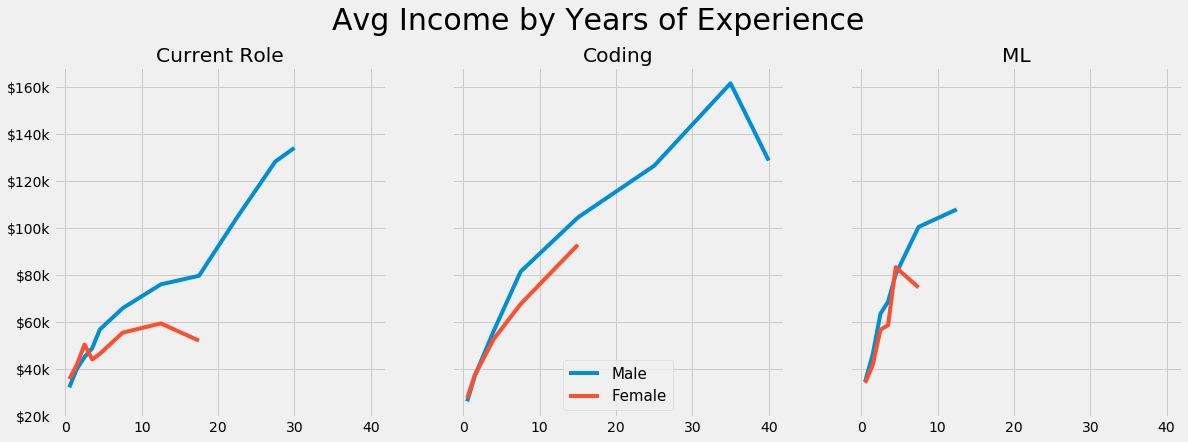

In [12]:
df_plot = sqldf("""
select gender, current_role_xp as experience, 'current_role_xp' as dimension, avg(income)*1.0/1000 as income_mean,  count(*) as population
from df
where current_role_xp is not null
group by 1, 2, 3
UNION ALL
select gender, coding_xp as experience, 'coding_xp' as dimension, avg(income)*1.0/1000 as income_mean,  count(*) as population
from df
where coding_xp is not null
group by 1, 2, 3
UNION ALL
select gender, ml_xp as experience, 'ml_xp' as dimension, avg(income)*1.0/1000 as income_mean,  count(*) as population
from df
where ml_xp is not null
group by 1, 2, 3
""")

df_plot = df_plot[df_plot['population']>=50]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6), sharey=True, sharex=True)
fig.suptitle('Avg Income by Years of Experience', fontsize=30, y=1.02)

ax1.plot('experience', 'income_mean', data=df_plot[(df_plot.gender=='Male') & (df_plot.dimension=='current_role_xp')])
ax1.plot('experience', 'income_mean', data=df_plot[(df_plot.gender=='Female') & (df_plot.dimension=='current_role_xp')])
ax1.set_title('Current Role')
ax1.yaxis.set_major_formatter(FormatStrFormatter('$%.0fk'))

ax2.plot('experience', 'income_mean', data=df_plot[(df_plot.gender=='Male') & (df_plot.dimension=='coding_xp')])
ax2.plot('experience', 'income_mean', data=df_plot[(df_plot.gender=='Female') & (df_plot.dimension=='coding_xp')])
ax2.legend(['Male', 'Female'], loc='lower center', prop={'size': 15})
ax2.set_title('Coding')

ax3.plot('experience', 'income_mean', data=df_plot[(df_plot.gender=='Male') & (df_plot.dimension=='ml_xp')])
ax3.plot('experience', 'income_mean', data=df_plot[(df_plot.gender=='Female') & (df_plot.dimension=='ml_xp')])
ax3.set_title('ML')

plt.show()

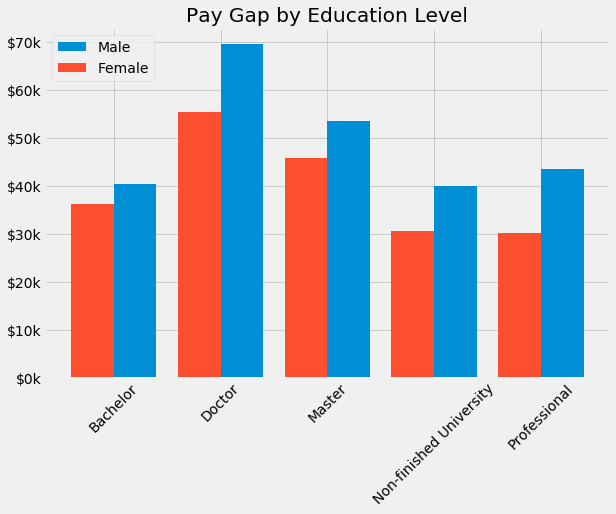

In [98]:
df_plot = sqldf("""
select gender, education, count(*) as population, avg(income)*1.0/1000 as income_mean
from df
where education is not null
group by 1, 2
having count(*)>=50
""")

df_plot = df_plot.pivot(index='education', columns='gender', values='income_mean')

education_level_order = ['Non Finished University', 'Bachelor', 'Professional', 'Master', 'Doctor']
df_plot = df_plot.reindex(education_level_order)

xticks = np.arange(len(df_plot.index))
xticklabels = list(df_plot.index)

fig, ax = plt.subplots(figsize=(9, 6))

ax.bar(xticks+0.2, 'Male', data=df_plot, width=0.4, label='Male')
ax.bar(xticks-0.2, 'Female', data=df_plot, width=0.4, label='Female')
ax.yaxis.set_major_formatter(FormatStrFormatter('$%.0fk'))
ax.legend(loc='upper left')
ax.set_title('Pay Gap by Education Level')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=45)

plt.show()


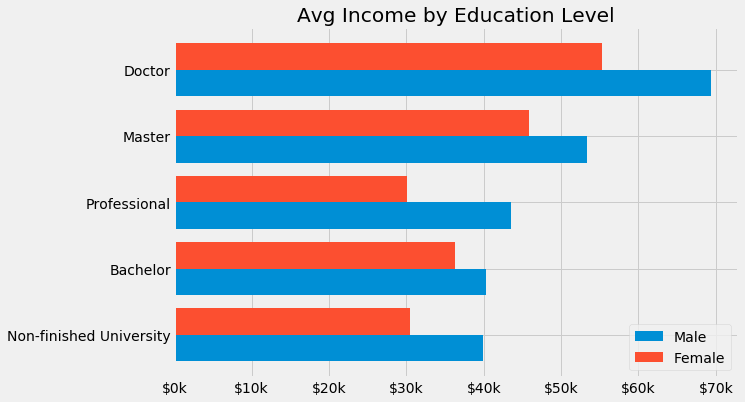

In [124]:
df_plot = sqldf("""
select gender, education, count(*) as population, avg(income)*1.0/1000 as income_mean
from df
where education is not null
group by 1, 2
having count(*)>=50
""")

df_plot = df_plot.pivot(index='education', columns='gender', values='income_mean')

education_level_order = ['Non-finished University', 'Bachelor', 'Professional', 'Master', 'Doctor']
df_plot = df_plot.reindex(education_level_order)

yticks = np.arange(len(df_plot.index))
yticklabels = list(df_plot.index)

fig, ax = plt.subplots(figsize=(9, 6))

yticks = np.arange(len(df_plot.index))
yticklabels = list(df_plot.index)

ax.barh(yticks-0.2, 'Male', data=df_plot, height=0.4, label='Male')
ax.barh(yticks+0.2, 'Female', data=df_plot, height=0.4, label='Female')
ax.set_title('Avg Income by Education Level')
ax.legend(loc='best')
ax.xaxis.set_major_formatter(FormatStrFormatter('$%.0fk'))
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

plt.show()